# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: {df.email.isna().sum()}")

Number of Null email values is: 17


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# Fill missing 'email' values with 'unknown_user'
df['email'].fillna('unknown_user', inplace=True)

/tmp/ipykernel_13/3869342773.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['email'].fillna('unknown_user', inplace=True)


In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?
print(f"There are {len(df['article_id'].unique())} unique article ids in the dataset, "
      f"{len(df['title'].unique())} unique titles, and "
      f"{len(df['email'].unique())} unique emails (users).")

user_interactions = df.groupby('email')['article_id'].count()
print(f"Median number of articles read per user: {user_interactions.median()} | "
      f"Maximum articles read by one user: {user_interactions.max()}")

There are 714 unique article ids in the dataset, 714 unique titles, and 5149 unique emails (users).
Median number of articles read per user: 3.0 | Maximum articles read by one user: 364


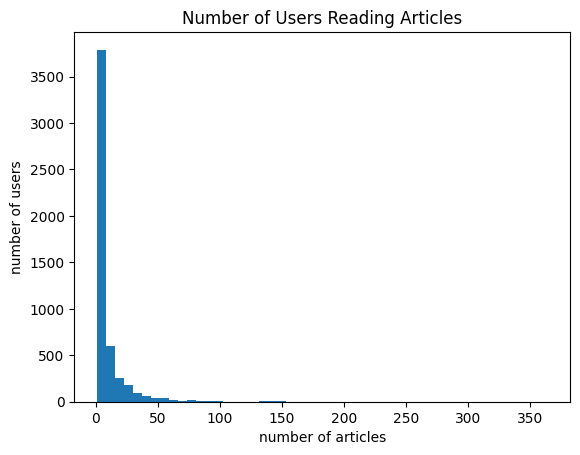

In [8]:
# Create a plot of the number of articles read by each user
plt.hist(user_interactions, bins=50)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

In [9]:
article_user_counts = df.groupby('article_id')['email'].count()

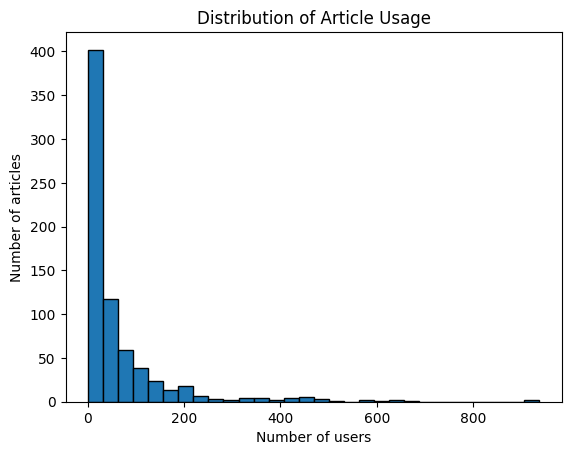

In [10]:
# Create a plot of the number of times each article was read
plt.hist(article_user_counts, bins=30, edgecolor='black')
plt.xlabel('Number of users')
plt.ylabel('Number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [11]:
# Fill in the median and maximum number of user_article interactions below
median_val = user_interactions.median()  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_interactions.max()# The maximum number of user-article interactions by any 1 user is ______.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
unique_articles = df['article_id'].nunique()   # The number of unique articles that have at least one interaction
total_articles = unique_articles   # The number of unique articles on the IBM platform
unique_users = df['email'].nunique()  # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
most_viewed_article_id = str(df['article_id'].value_counts().index[0])  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max()  # The most viewed article in the dataset was viewed how many times?

In [14]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The article_id of the most viewed article is ______.` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    # Count how many times each article title appears (i.e., number of user interactions per article)
    # Then get the top n article titles with the most interactions
    top_articles = df['title'].value_counts().index[:n].tolist()
    return top_articles

def get_top_article_ids(n, df=df):
    # Count how many times each article_id appears (i.e., number of user interactions per article)
    # Get the top n article IDs with the most interactions
    # Convert each article_id to float then to string to keep consistent formatting
    top_articles = df['article_id'].value_counts().index[:n].tolist()
    return [str(float(x)) for x in top_articles]

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Fill in the function here
    # Create a user-item matrix with user_id as rows and article_id as columns
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    # Fill NaN values with 0
    user_item = user_item.fillna(0)
    # Convert the other values to 1
    user_item[user_item != 0] = 1
    
    return user_item # return the user_item matrix 

# Create the actual matrix with the function
user_item = create_user_item_matrix(df)

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [21]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
     
    similarity = user_item.dot(user_item.loc[user_id])
    
    similarity = similarity.sort_values(ascending=False)
    

    similarity = similarity.drop(user_id)
    
    if include_similarity:
        return list(zip(similarity.index, similarity.values)) # return a list of lists with [[similar_user_id, similarity], ...]
    return similarity.index.tolist() # return a list of the users in order from most to least similar

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - list of article IDs
    df - DataFrame containing 'article_id' and 'title'

    OUTPUT:
    article_names - list of unique article titles corresponding to given IDs
    """
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - integer ID of the user
    user_item - user-item matrix with 1 if article was read, 0 otherwise

    OUTPUT:
    article_ids - list of article IDs read by the user
    article_names - list of article titles read by the user
    """
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    article_names = get_article_names(article_ids)
    return article_ids, article_names


def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - list of article IDs
    user_item - user-item matrix

    OUTPUT:
    ranked_article_unique_counts - list of [article_id, count] pairs,
                                   sorted by unique user count descending
    """
    # Get sub-matrix for given articles
    selected_articles = user_item[article_ids]
    
    # Count how many users read each article
    article_counts = selected_articles.sum(axis=0).sort_values(ascending=False)
    
    # Convert to list of [article_id, user_count]
    ranked_article_unique_counts = [[article_id, int(count)] for article_id, count in article_counts.items()]
    
    return ranked_article_unique_counts


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - user ID to get recommendations for
    m - number of recommendations to return

    OUTPUT:
    recs - list of recommended article IDs

    Description:
    Recommends articles that similar users have read, but the input user has not.
    Articles are ranked by how many unique users read them (more popular first).
    """
    recs = []
    
    # Articles the target user already read
    user_articles, _ = get_user_articles(user_id)
    
    # Find users similar to this one
    similar_users = find_similar_users(user_id, include_similarity=False)
    
    i = 0
    while len(recs) < m and i < len(similar_users):
        # Articles the similar user has read
        sim_user_articles, _ = get_user_articles(similar_users[i])
        
        # Rank those articles by number of unique readers
        ranked_articles = get_ranked_article_unique_counts(sim_user_articles)

        for article_id, _ in ranked_articles:
            # Recommend only if not seen by target user and not already in recommendations
            if article_id not in user_articles and article_id not in recs:
                recs.append(article_id)
                if len(recs) == m:
                    break
        i += 1

    return recs


In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'predicting churn with the spss random tree algorithm',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'model bike sharing data with spss',
 'analyze accident reports on amazon emr spark',
 'python machine learning: scikit-learn tutorial',
 'movie recommender system with spark machine learning',
 'learn basics about notebooks and apache spark']

In [26]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # Your code here
    # Hint: find similar users, but include their similarity, from there we can find the number of interactions for each neighbor

    # Find similar users for the current user and get the similarity scores
    similar_users = find_similar_users(user_id, include_similarity=True)
    # Create a dataframe from the similar users
    neighbors_df = pd.DataFrame(similar_users, columns=['user_id', 'similarity'])
    # Add the number_interactions column to the dataframe
    neighbors_df['num_interactions'] = neighbors_df['user_id'].apply(lambda x: user_item[user_item.index == x].sum(axis=1).values[0])
    # Sort it
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    #neighbors_df.head(20) # for debugging purpose
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # Your code here

    # Initialize the list of recommendations
    recs = []
    # Get the articles read by the current user
    own_user_articles = get_user_articles(user_id=user_id, user_item=user_item)
    # print(own_user_articles[0]) # for debugging purpose

    # Find similar sorted users for the current user
    similar_users = get_top_sorted_users(user_id)

    # Loop through the similar users
    i = 0
    while len(recs) < m:
        similar_user = int(similar_users.iloc[i,:].user_id)
        # print(f"User {i}: {similar_user}") # for debugging purpose
        similar_user_articles = get_user_articles(user_id=similar_user, user_item=user_item)
        similar_user_ranked_article_unique_counts = get_ranked_article_unique_counts(similar_user_articles[0], user_item)

        # Count up for next loop run
        i += 1

        # Loop through the ranked articles read by the similar user
        for j in range(len(similar_user_ranked_article_unique_counts)):
            # print(similar_user_ranked_article_unique_counts[0])
            if similar_user_ranked_article_unique_counts[j][0] not in (own_user_articles[0] or recs):
                recs.append(similar_user_ranked_article_unique_counts[j][0])
                if len(recs) >= 10:
                    break
    
    return recs, get_article_names(recs) # return your recommendations for this user_id

In [40]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330, 1429, 1314, 1271, 43, 1351, 1336, 1368, 151, 1338]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'putting a human face on machine learning', 'insights from new york car accident reports', 'model bike sharing data with spss', 'jupyter notebook tutorial', 'deep learning with tensorflow course by big data university', 'learn basics about notebooks and apache spark', 'customer demographics and sales']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [41]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   user_id  similarity  num_interactions
0     3933        35.0              35.0
    user_id  similarity  num_interactions
2        49         5.0             101.0
1      3697         5.0             100.0
0        98         5.0              97.0
3      3764         5.0              97.0
5      3782         4.0             135.0
11       23         4.0             135.0
13     4785         4.0              62.0
12       21         4.0              61.0
9      2982         4.0              58.0
14      290         4.0              58.0
    user_id  similarity  num_interactions
0      3870        74.0              75.0
1      3782        39.0             135.0
2        23        38.0             135.0
3       203        33.0              96.0
4      4459        33.0              96.0
5        49        29.0             101.0
8      3697        29.0             100.0
6      3764        29.0              97.0
7        98        29.0              97.0
10     3910        25.0             

In [42]:
user1_most_sim = 3933    # The user most similar to user 1
user2_6th_sim = 3586     # The 6th most similar user to user 2
user131_10th_sim = 383   # The 10th most similar user to user 131

In [43]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [46]:
# For a completely new user (user 0) with no interaction history, 
# we recommend the most popular articles overall
new_user_recs = get_top_article_ids(10)  # This returns the top 10 article IDs

# Convert the string IDs to integers for the assertion test
new_user_recs_int = [int(float(x)) for x in new_user_recs]

print(f'Recommendations for new user: {new_user_recs}')

# Now test with the integer versions
assert set(new_user_recs_int) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, \
    "Oops! It makes sense that in this case we would want to recommend the most popular articles."

print("That's right! Nice job!")

Recommendations for new user: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
That's right! Nice job!


In [ ]:
Part IV: Content Based Recommendations
Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles. Let's consider content to be the article title, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.

1. Use the function bodies below to create a content based recommender function make_content_recs. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [47]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [48]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [49]:
# unique articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates()
df_unique_articles

,article_id,title
0,1430,"using pixiedust for fast, flexible, and easier..."
1,1314,healthcare python streaming application demo
2,1429,use deep learning for image classification
3,1338,ml optimization using cognitive assistant
4,1276,deploy your python model as a restful api
...,...,...
24278,1156,airbnb data for analytics: washington d.c. cal...
24616,555,build a naive-bayes model with wml & dsx
24726,708,load and analyze public data sets in dsx
24737,575,the new builders ep. 13: all the data that’s f...


In [53]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf =  vectorizer.fit_transform(df_unique_articles['title']) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


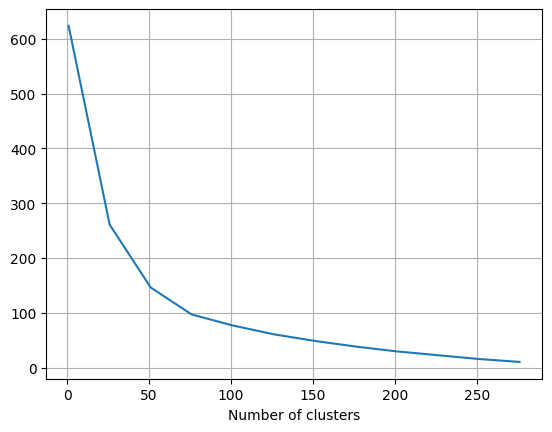

In [54]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')
plt.grid()

There appears to be an elbow about 50, so we'll use 50 clusters.

In [55]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
).fit(X_lsa)

In [56]:
# Step 1: Create a dictionary mapping each article_id to its kmeans cluster label
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_))

# Step 2: Use the map to create a new column 'title_cluster' in df, assigning cluster labels based on article_id
df['title_cluster'] = df['article_id'].map(article_cluster_map)

# Optional: cast the 'title_cluster' to int if you want, but not necessary for clustering
# df['title_cluster'] = df['title_cluster'].astype('Int64')  # Nullable integer type to keep NaNs if any

# Display the dataframe to check the new column
df.head()

,Unnamed: 0,article_id,title,user_id,title_cluster
0,0,1430,"using pixiedust for fast, flexible, and easier...",1,45
1,1,1314,healthcare python streaming application demo,2,48
2,2,1429,use deep learning for image classification,3,31
3,3,1338,ml optimization using cognitive assistant,4,32
4,4,1276,deploy your python model as a restful api,5,19


In [57]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 10],
       [ 1, 37],
       [ 2, 23],
       [ 3, 63],
       [ 4, 11],
       [ 5, 28],
       [ 6, 18],
       [ 7, 19],
       [ 8,  4],
       [ 9, 20],
       [10,  3],
       [11,  2],
       [12,  8],
       [13, 31],
       [14,  9],
       [15, 27],
       [16, 10],
       [17, 15],
       [18, 26],
       [19, 13],
       [20,  9],
       [21, 11],
       [22,  7],
       [23,  7],
       [24, 18],
       [25, 13],
       [26, 40],
       [27, 10],
       [28, 19],
       [29,  7],
       [30, 12],
       [31, 20],
       [32, 13],
       [33,  8],
       [34, 16],
       [35,  9],
       [36,  8],
       [37,  7],
       [38,  5],
       [39, 10],
       [40,  8],
       [41, 10],
       [42, 10],
       [43, 10],
       [44,  8],
       [45, 14],
       [46,  3],
       [47,  9],
       [48,  8],
       [49,  8]])

In [58]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Your code here
    # Get the title cluster for the input article_id
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    # Get the article ids in the same title cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'].unique().tolist()
    
    # Remove the input article_id from the list
    articles_in_cluster.remove(article_id)
    
    return articles_in_cluster

In [59]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here
    # Get the similar articles
    recommended_articles = get_similar_articles(article_id)
    # Rank the articles
    ranked_articles = get_ranked_article_unique_counts(recommended_articles)
    # Limit the number of articles to n
    n_ranked_similar_articles = ranked_articles[:n]
    # Only extract the article ids
    n_ranked_similar_articles = [x[0] for x in n_ranked_similar_articles]
    # Get the article titles
    n_ranked_article_names = get_article_names(n_ranked_similar_articles)
    
    return n_ranked_similar_articles, n_ranked_article_names 

In [60]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 593, 349, 101, 821, 975, 766, 508, 464, 547]
['upload files to ibm data science experience using the command line', 'ibm data science experience white paper - sparkr transforming r into a tool for big data analytics', 'data science in the cloud', 'making data science a team sport', 'how to choose a project to practice data science', 'data tidying in data science experience', 'trust in data science', 'the data science process', 'using rstudio in ibm data science experience', 'use ibm data science experience to detect time series anomalies']


In [61]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [62]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [63]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

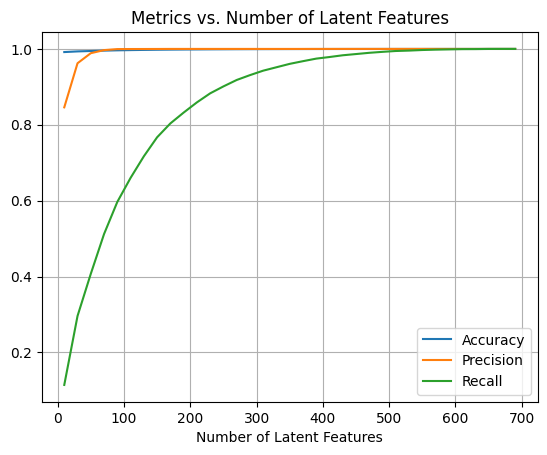

In [64]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')
plt.grid()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [65]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(article_id)
    
    # Calculate cosine similarity between all articles
    # Transpose vt to get article features as rows
    article_features = vt.T
    cos_sim = cosine_similarity(article_features)
    
    # Get similarity scores for our target article
    sim_scores = list(enumerate(cos_sim[article_idx]))
    
    # Sort articles by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top similar articles (excluding the article itself)
    sim_scores = sim_scores[1:11]  # Top 10 similar articles
    
    # Get article indices and similarity scores
    similar_articles = [(user_item.columns[i], score) for i, score in sim_scores]
    
    if include_similarity:
        return similar_articles  # return list of (article_id, similarity) tuples
    else:
        return [article for article, score in similar_articles]  # return just article ids

In [66]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]
vt_new

array([[ 0.00221822,  0.02604036,  0.00246327, ...,  0.00050441,
         0.00492688,  0.00404343],
       [-0.00207737,  0.0281658 , -0.00051368, ..., -0.00262161,
        -0.01325774, -0.01327298],
       [ 0.00043211, -0.0135172 , -0.00300468, ..., -0.00157638,
        -0.01481189, -0.00798957],
       ...,
       [ 0.00052298,  0.03114128,  0.0412575 , ..., -0.00481181,
         0.02392748,  0.01149674],
       [ 0.01517699,  0.03271468, -0.00647556, ..., -0.00124832,
        -0.0036916 , -0.02407027],
       [ 0.01029133,  0.00532077, -0.01000918, ..., -0.00263044,
         0.04288296,  0.02769194]])

In [67]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [68]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[np.int64(1199),
 np.int64(1068),
 np.int64(486),
 np.int64(1202),
 np.int64(176),
 np.int64(1120),
 np.int64(244),
 np.int64(793),
 np.int64(58),
 np.int64(132)]

In [69]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [70]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [72]:
from subprocess import call
call(['jupyter', 'nbconvert', '--to', 'html', 'Recommendations_with_IBM.ipynb'])


[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 570647 bytes to Recommendations_with_IBM.html


0